# OKfinal_RNN_insurance-weeks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [3]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [4]:
data

,total_amount_claims
0,16683
1,201774
2,263661
3,799703
4,900305
...,...
127,1949930
128,1725225
129,2232202
130,2666662


In [5]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  16683
max:  2666662


In [6]:
data.shape

(132, 1)

In [7]:
min_ = data['total_amount_claims'].min()
max_ = data['total_amount_claims'].max()

data['total_amount_claims'] = [((x - min_) / (max_ - min_)) for x in data['total_amount_claims']]

In [8]:
data

,total_amount_claims
0,0.000000
1,0.069846
2,0.093200
3,0.295482
4,0.333445
...,...
127,0.729533
128,0.644738
129,0.836052
130,1.000000


### Split data

In [9]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

In [10]:
print(data_train.shape)
print(data_test.shape)

(105, 1)
(27, 1)


### Sequences

In [11]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [12]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
32,0.336549
33,0.047074
34,0.176394
35,0.270285
36,0.181692
37,0.141791
38,0.168553
39,0.117724
40,0.134364
41,0.102333


In [13]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [14]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [19]:
X_train, y_train = get_X_y(data_train, 80, 26)
X_test, y_test = get_X_y(data_test, 20, 26)

In [20]:
y_true = data_test.values.T[0]

In [21]:
# !pip install tensorflow

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()

model.add(layers.LSTM(32, activation='tanh', return_sequences=False))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(1, activation='linear'))

In [23]:
model.compile(optimizer='RMSprop',
            loss='MeanSquaredError',
            metrics=['mse', 'mae', 'mape'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=50, restore_best_weights=False)

history = model.fit(X_train, y_train,
                validation_split=0.2,
                epochs=200,
                verbose=1,
                batch_size=32,
                callbacks=[es]
                )

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8

In [26]:
data_test.shape

(27, 1)

In [27]:
model_eval = model.evaluate(X_test, y_test)
print(f'Model Mean Squeared Error {model_eval[1]:.4f}')
print(f'Model Mean Absolute Error {model_eval[2]:.4f}')
print(f'Model Mean Absolute Porcentual Error {model_eval[3]:.4f}')

1/1 [==============================] - 0s 28ms/step - loss: 0.5496 - mse: 0.5496 - mae: 0.7414 - mape: 74.1366
Model Mean Squeared Error 0.5496
Model Mean Absolute Error 0.7414
Model Mean Absolute Porcentual Error 74.1366


In [23]:
# tf.keras.losses.MAPE(y_true, y_pred)

#### Prediction

In [28]:
y_pred = model.predict(y_true)

ValueError: in user code:

    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/lucila/.pyenv/versions/3.8.6/envs/Insurance_claiming_forecasting/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)


In [29]:
y_pred.shape

NameError: name 'y_pred' is not defined

In [66]:
y_pred

array([[0.5769721 ],
       [0.5654931 ],
       [0.7905639 ],
       [0.8328225 ],
       [0.50814444],
       [0.50814444],
       [0.5769721 ],
       [0.47892725],
       [0.5769721 ],
       [0.5769721 ],
       [0.5769721 ],
       [0.46469563],
       [0.8328225 ],
       [0.5517933 ],
       [0.5860829 ],
       [0.5860829 ],
       [0.6803949 ],
       [0.5351182 ],
       [0.46469563],
       [0.5517932 ]], dtype=float32)

In [37]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_true, y_pred)

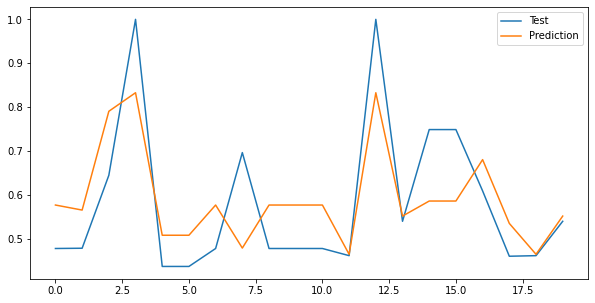

In [67]:
plt.figure(figsize=(10,5))
plt.plot(y_test,label = 'Test')
plt.plot(y_pred, label = 'Prediction')
plt.legend(loc='best')
plt.show()

### Reversion

In [28]:
# def rev_min_max_func(scaled_val):
#     max_val = max(df['target'])
#     min_val = min(df['target'])
#     og_val = (scaled_val*(max_val - min_val)) + min_val
#     return og_val
# df['pred_target'] = scaled_labeled_df['pred_scaled_target'].apply(lambda x: rev_min_max_func(x))

In [29]:
data['total_amount_claims'] = [((x*(max_ - min_)) + min_) for x in data['total_amount_claims']]

In [30]:
data['total_amount_claims']

0        16683.0
1       201774.0
2       263661.0
3       799703.0
4       900305.0
         ...    
127    1949930.0
128    1725225.0
129    2232202.0
130    2666662.0
131    2111986.0
Name: total_amount_claims, Length: 132, dtype: float64

In [31]:
y_pred = [((x*(max_ - min_)) + min_) for x in y_pred]

In [32]:
y_pred

[array([1197923.37540248]),
 array([1144926.68906584]),
 array([1747292.39377677]),
 array([1789145.47509402]),
 array([1035516.51912847]),
 array([1035516.51912847]),
 array([1197923.37540248]),
 array([1028893.55233473]),
 array([1197923.37540248]),
 array([1197923.37540248]),
 array([1197923.37540248]),
 array([987968.67040369]),
 array([1789145.47509402]),
 array([1147499.71178368]),
 array([1308933.5105713]),
 array([1308933.5105713]),
 array([1587282.12888998]),
 array([1149542.88768095]),
 array([987968.67040369]),
 array([1147499.79075921])]

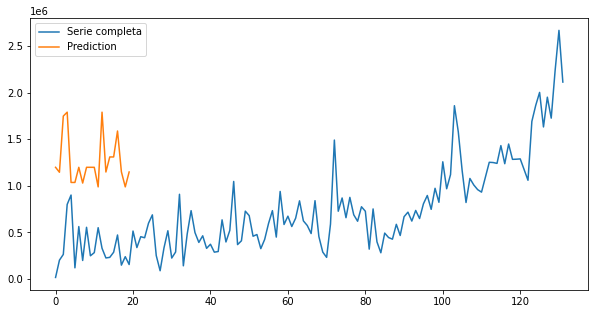

In [33]:
plt.figure(figsize=(10,5))
plt.plot(data['total_amount_claims'],label = 'Serie completa')
plt.plot(y_pred, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [34]:
data_orig = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [35]:
data_orig = data_orig.drop(columns='Unnamed: 0')

In [36]:
data_orig

,date_issue,total_amount_claims
0,2018-09-03,16683
1,2018-09-10,201774
2,2018-09-17,263661
3,2018-09-24,799703
4,2018-10-01,900305
...,...,...
127,2021-02-08,1949930
128,2021-02-15,1725225
129,2021-02-22,2232202
130,2021-03-01,2666662


In [37]:
data['total_amount_claims'].index = pd.to_datetime(data_orig.iloc[:, 0]) #relaciona indices

In [38]:
data['total_amount_claims'].reset_index()

,date_issue,total_amount_claims
0,2018-09-03,16683.0
1,2018-09-10,201774.0
2,2018-09-17,263661.0
3,2018-09-24,799703.0
4,2018-10-01,900305.0
...,...,...
127,2021-02-08,1949930.0
128,2021-02-15,1725225.0
129,2021-02-22,2232202.0
130,2021-03-01,2666662.0


In [39]:
data['y_pred'] = pd.DataFrame(y_pred)
data[['y_pred']]

,y_pred
0,1.197923e+06
1,1.144927e+06
2,1.747292e+06
3,1.789145e+06
4,1.035517e+06
...,...
127,NaN
128,NaN
129,NaN
130,NaN


In [40]:
len_ = int(0.8*data.shape[0])
len_
# data_train = data[:len_]
# data_test = data[len_:]

105

In [41]:
data[['y_pred']].index = pd.to_datetime(data_orig.iloc[105:, 0])

ValueError: Length mismatch: Expected axis has 132 elements, new values have 27 elements